This project uses this reference https://www.tensorflow.org/recommenders?hl=en to make recommandation books for an user using
<font color='red'>building deep</font> retrieval models. 





# The dataset

The Books dataset is a classic dataset from kaggle page. It contains a set of ratings given to books by a set of users, and is a workhorse of recommender system research.

The data can be treated in the following way:

It can be interpreted as expressesing which books the users read (and rated), and which they did not, and it can also be seen as expressesing how much the users liked the books they did read. 

This is a form of explicit feedback: given that a user read a book, we can tell roughly how much they liked by looking at the rating they have given.

In this project, we are focusing on a retrieval system: a model that predicts a set of books from the catalogue that the user is likely to read by looking at the rating another users have given.

In this project, we will illustrate how to build deep retrieval models using TensorFlow Recommenders. 

# Import libraries

First get our imports out of the way.

In [1]:
!pip install -q tensorflow-recommenders

     |████████████████████████████████| 81kB 5.7MB/s 


In [2]:
import pandas as pd
import os
import tempfile

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

plt.style.use('seaborn-whitegrid')

In [3]:
print('Version of tensorflow is:', tf.__version__)

Version of tensorflow is: 2.5.0


# Read dataframe files from Google Drive

In [4]:
# To read csv file from Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# https://drive.google.com/file/d/1zX4wqgmcd7EHmqPHqH--VKTSf50JqG4o/view?usp=sharing
fileDownload1 = drive.CreateFile({'id':'1zX4wqgmcd7EHmqPHqH--VKTSf50JqG4o'})
fileDownload1.GetContentFile('books.csv')

# https://drive.google.com/file/d/1mHPCPwH9W9S-_WxZV1k-1cI7TjHfRPqX/view?usp=sharing
fileDownload2 = drive.CreateFile({'id':'1mHPCPwH9W9S-_WxZV1k-1cI7TjHfRPqX'})
fileDownload2.GetContentFile('ratings.csv')

# Preparing the dataset

Let's have a look at the data.

In [7]:
# Features of all the available books.
books_df = pd.read_csv("books.csv")

# Ratings data.
ratings_df = pd.read_csv("ratings.csv")

In [8]:
books_df.head(5)

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [9]:
ratings_df.head(5)

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
# !pip3 install spacy_langdetect

In [ ]:
# from spacy_langdetect import LanguageDetector
# import spacy
# nlp = spacy.load('en')
# nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

In [ ]:
# language_title = []
# for i in range(len(books_df['title'])):
#   doc = nlp(books_df.loc[i,'title'])
#   language_title.append(doc._.language['language'])
#   print(i)


In [ ]:
# books_df.insert(10, "language", language_title)

In [ ]:
# from spacy_langdetect import LanguageDetector
# import spacy
# nlp = spacy.load('en')
# nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
# text_content = 'My name is Khaled'
# doc = nlp(text_content)
# nlp(text_content)._.language['language']
# detect_language = doc._.language
# books_df.drop(books_df[nlp(str(books_df.title))._.language['language'] == 'en'].index)


Create a new dataframe with two columns 'book id' and 'title' from books dataframe to use it after in order to add new column 'title' to ratings dataframe.

In [10]:
Books_id_title = books_df[['book_id','title']]

In [11]:
Books_id_title.head(5)

,book_id,title
0,1,"The Hunger Games (The Hunger Games, #1)"
1,2,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,"Twilight (Twilight, #1)"
3,4,To Kill a Mockingbird
4,5,The Great Gatsby


Add a column 'title' to ratings using left union with the dataframe 'Books_id_title'

In [12]:
ratings_df = pd.merge(ratings_df, Books_id_title, left_on="book_id", right_on="book_id", how="left")

In [13]:
ratings_df.head(5)

,user_id,book_id,rating,title
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...
1,2,4081,4,I am Charlotte Simmons
2,2,260,5,How to Win Friends and Influence People
3,2,9296,5,The Drama of the Gifted Child: The Search for ...
4,2,2318,3,The Millionaire Next Door: The Surprising Secr...


We need to convert values of 'user_id', 'book_id' and 'title' to str so fit with tensorflow-recommenders library.

In [14]:
ratings_df['user_id'] = ratings_df['user_id'].astype(str)
ratings_df['book_id'] = ratings_df['book_id'].astype(str)

In [15]:
ratings_df.dtypes

user_id    object
book_id    object
rating      int64
title      object
dtype: object

In [16]:
books_df['title'] = books_df['title'].astype(str)

Check if there are none value in ratings dataframe.

In [17]:
ratings_df.isna().sum()

user_id    0
book_id    0
rating     0
title      0
dtype: int64

Now, this step is very important, we need to convert dataframe to tensorflow dataset that Tensorflow can read.

We're going to focus on the ratings data. 

We keep only the user_id, book_id, title and rating fields in the dataset.

In [18]:
ratings = (
    tf.data.Dataset.from_tensor_slices(
        {
            'user_id' : tf.cast(ratings_df['user_id'].values, tf.string),
            'book_id': tf.cast(ratings_df['book_id'].values, tf.string),
            'title': tf.cast(ratings_df['title'].values, tf.string),
            'rating': tf.cast(ratings_df['rating'].values, tf.int64),

        }
    )
)

In [19]:
ratings

<TensorSliceDataset shapes: {user_id: (), book_id: (), title: (), rating: ()}, types: {user_id: tf.string, book_id: tf.string, title: tf.string, rating: tf.int64}>

The ratings dataset returns a dictionary of user id, book id, title and rating:

In [20]:
for x in ratings.take(1).as_numpy_iterator():
  print(x)

{'user_id': b'1', 'book_id': b'258', 'title': b'The Shadow of the Wind (The Cemetery of Forgotten Books,  #1)', 'rating': 5}


In [21]:
books = (
    tf.data.Dataset.from_tensor_slices(
        (
         tf.cast(books_df['title'].values, tf.string)
        )
    )
)

In [22]:
books

<TensorSliceDataset shapes: (), types: tf.string>

The books dataset contains the book title. Note that the genres are encoded with integer labels.

In [23]:
for x in books.take(1).as_numpy_iterator():
  print(x)

b'The Hunger Games (The Hunger Games, #1)'


Let's figure out unique user ids and movie titles present in the data.

This is important because we need to be able to map the raw values of our categorical features to embedding vectors in our models. To do that, we need a vocabulary that maps a raw feature value to an integer in a contiguous range: this allows us to look up the corresponding embeddings in our embedding tables.

In [24]:
unique_books_titles = np.unique(np.concatenate(list(books.batch(1000))))

In [25]:
unique_books_titles

array([b' Angels (Walsh Family, #3)',
       b'"\xd8\xad\xd9\x83\xd8\xa7\xd9\x8a\xd8\xa7\xd8\xaa \xd9\x81\xd8\xb1\xd8\xba\xd9\x84\xd9\x8a \xd8\xa7\xd9\x84\xd9\x85\xd8\xb3\xd8\xaa\xd9\x83\xd8\xa7\xd9\x88\xd9\x8a "\xd8\xad\xd9\x83\xd8\xa7\xd9\x8a\xd8\xaa\xd9\x89 \xd9\x85\xd8\xb9 \xd9\x83\xd9\x81\xd8\xb1 \xd8\xa7\xd9\x84\xd8\xb3\xd8\xad\xd9\x84\xd8\xa7\xd9\x88\xd9\x8a\xd8\xa9',
       b'#GIRLBOSS', ...,
       b'\xda\xa4\xd9\x8a\xd8\xb1\xd8\xaa\xd9\x8a\xd8\xac\xd9\x88',
       b'\xe3\x82\xad\xe3\x82\xb9\xe3\x82\x88\xe3\x82\x8a\xe3\x82\x82\xe6\x97\xa9\xe3\x81\x8f1 [Kisu Yorimo Hayaku 1] (Faster than a Kiss #1)',
       b'\xe7\xbe\x8e\xe5\xb0\x91\xe5\xa5\xb3\xe6\x88\xa6\xe5\xa3\xab\xe3\x82\xbb\xe3\x83\xbc\xe3\x83\xa9\xe3\x83\xbc\xe3\x83\xa0\xe3\x83\xbc\xe3\x83\xb3\xe6\x96\xb0\xe8\xa3\x85\xe7\x89\x88 1 [Bish\xc5\x8djo Senshi Sailor Moon Shins\xc5\x8dban 1]'],
      dtype=object)

We need to do decode for values

In [26]:
unique_books_titles = np.array([x.decode('utf-8') for x in unique_books_titles])

In [27]:
unique_books_titles

array([' Angels (Walsh Family, #3)',
       '"حكايات فرغلي المستكاوي "حكايتى مع كفر السحلاوية', '#GIRLBOSS',
       ..., 'ڤيرتيجو',
       'キスよりも早く1 [Kisu Yorimo Hayaku 1] (Faster than a Kiss #1)',
       '美少女戦士セーラームーン新装版 1 [Bishōjo Senshi Sailor Moon Shinsōban 1]'],
      dtype='<U186')

In [28]:
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(lambda x: x["user_id"]))))

In [29]:
unique_user_ids

array([b'1', b'10', b'100', ..., b'9997', b'9998', b'9999'], dtype=object)

# Model definition

## Query model

We start with the user model defined in the <a href="https://www.tensorflow.org/recommenders/examples/featurization">featurization tutorial</a> as the first layer of our model, tasked with converting raw input examples into feature embeddings.

In [30]:
class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])


  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"]),], axis=1)


We will use ReLU activations for all but the last hidden layer. The final hidden layer does not use any activation function: using an activation function would limit the output space of the final embeddings and might negatively impact the performance of the model. For instance, if ReLUs are used in the projection layer, all components in the output embedding would be non-negative.

In [31]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

The layer_sizes parameter gives us the depth and width of the model. We can vary it to experiment with shallower or deeper models.

## Candidate model

We can adopt the same approach for the bookmodel. Again, we start with the MovieModel from the <a href="https://www.tensorflow.org/recommenders/examples/featurization">featurization tutorial</a>:

In [32]:
class BookModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_books_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_books_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(books)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

And expand it with hidden layers:

In [33]:
class CandidateModel(tf.keras.Model):
  """Model for encoding books."""

  def __init__(self, layer_sizes):
    """Model for encoding books.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = BookModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

## Combined model

With both QueryModel and CandidateModel defined, we can put together a combined model and implement our loss and metrics logic. To make things simple, we'll enforce that the model structure is the same across the query and candidate models.

In [34]:
class BooklensModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=books.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        'user_id': features['user_id'],
        'book_id': features['book_id'],
        'rating': features['rating'],

    })
    
    book_embeddings = self.candidate_model(features["title"])

    return self.task(
        query_embeddings, book_embeddings, compute_metrics=not training)

# Training the model

## Prepare the data

To fit and evaluate the model, we need to split it into a training and evaluation set.

In this example, we use a random split, putting 80% of the ratings in the train set, and 20% in the test set.

In [35]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Number of epochs used

In [36]:
num_epochs = 300

# Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [37]:
model = BooklensModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

Then shuffle, batch, and cache the training and evaluation data.

In [38]:
cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

Then train the model:

In [39]:
one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Top-100 accuracy: 0.20.


This gives us a top-100 accuracy of around 0.2, we can use this as a reference point for evaluating deeper models.

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

# Evaluate model

Finally, we can evaluate our model on the test set:

In [40]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 13s 3s/step - factorized_top_k/top_1_categorical_accuracy: 4.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0022 - factorized_top_k/top_10_categorical_accuracy: 0.0083 - factorized_top_k/top_50_categorical_accuracy: 0.0897 - factorized_top_k/top_100_categorical_accuracy: 0.2019 - loss: 54856.9134 - regularization_loss: 0.0000e+00 - total_loss: 54856.9134


{'factorized_top_k/top_100_categorical_accuracy': 0.20190000534057617,
 'factorized_top_k/top_10_categorical_accuracy': 0.008349999785423279,
 'factorized_top_k/top_1_categorical_accuracy': 0.00044999999227002263,
 'factorized_top_k/top_50_categorical_accuracy': 0.08969999849796295,
 'factorized_top_k/top_5_categorical_accuracy': 0.0022499999031424522,
 'loss': 51176.1953125,
 'regularization_loss': 0,
 'total_loss': 51176.1953125}

Test set performance is much worse than training performance. This is due to two factors:

This model is likely to perform better on the data that it has seen, simply because it can memorize it. This overfitting phenomenon is especially strong when models have many parameters. It can be mediated by model regularization and use of user and book features that help the model generalize better to unseen data.

The second phenomenon can be tackled by excluding previously seen books from test recommendations. 

# Deeper model

In [41]:
model = BooklensModel([64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.15.


The accuracy here is 0.16, a little lower than the shallow shape.

We can plot the validation accuracy curves to illustrate this:

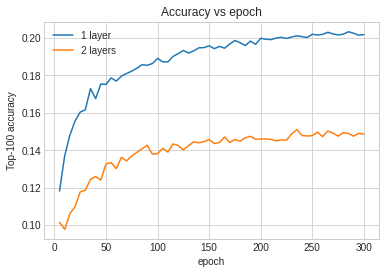

In [42]:
num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [64]:
model = BooklensModel([128, 64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

three_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.12.


In fact, we don't see improvement over the shallow model.

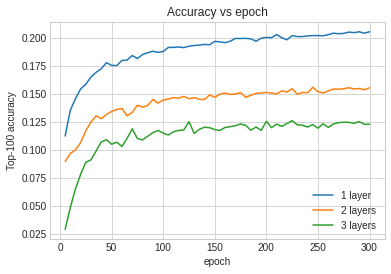

In [65]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

# conclusion

The best accuracy was with one layer. We note whenever we increment one layer, the accuracy decrement, but when we add number of epochs the accuracy increment.

The deeper and larger models, while capable of superior performance, often require very careful tuning. 

With appropriate tuning and sufficient data, the effort put into building larger and deeper models is in many cases well worth it: larger models can lead to substantial improvements in prediction accuracy.